<a href="https://colab.research.google.com/github/MihailMV/Fruits-and-vegetables/blob/master/NN_fruits_and_vegetables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import zipfile
import shutil
import numpy as np
from tqdm import tqdm

In [0]:
DIR = 'fruits_vegetables'
DIR_TRAIN = 'TRAIN'
DIR_VAL = 'VAL'
DIR_TEST = 'TEST'
IMG_SIZE = (224, 224)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
BATCH_SIZE = 50

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/kaggle/" 

In [4]:
!kaggle datasets download -d balalexv/fruits-vegetables-photos
with zipfile.ZipFile('/content/fruits-vegetables-photos.zip', 'r') as zip_obj:
   zip_obj.extractall('/content/')
!rm '/content/fruits-vegetables-photos.zip'

 99% 1.78G/1.80G [00:20<00:00, 99.8MB/s]
100% 1.80G/1.80G [00:20<00:00, 95.5MB/s]


In [0]:
os.makedirs(os.path.join(DIR, DIR_VAL), exist_ok=True)

for class_name in os.listdir(os.path.join(DIR,DIR_TRAIN)):
  os.makedirs(os.path.join(DIR, DIR_VAL, class_name), exist_ok=True)
  for i, f in enumerate(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))):
    if (i % 5 == 0):
      shutil.move(os.path.join(DIR,DIR_TRAIN, class_name,f), os.path.join(DIR,DIR_VAL,class_name,f))

In [0]:
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torchvision
import torch
import matplotlib.pyplot as plt

In [0]:
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TRAIN), train_transforms)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_VAL), val_transforms)


In [0]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


In [0]:
#for inputs, labels in val_dataloader:
#  inputs_t = inputs




In [0]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = STD * image + MEAN
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)


In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
  hist_loss_train = []
  hist_acc_train = []
  hist_loss_val = []
  hist_acc_val = []
  for epoch in range(num_epochs):
    # Train
    running_loss = 0.
    running_acc = 0.
    model.train()
    #for inputs, labels in tqdm(train_dataloader):
    for inputs, labels in train_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      with torch.set_grad_enabled(True):
        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)
        loss_value.backward()
        optimizer.step()
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()
        loss_train = running_loss / len(train_dataloader)
        acc_train = running_acc / len(train_dataloader)
    scheduler.step(loss_train)
    # Val
    running_loss = 0.
    running_acc = 0.
    model.eval()
    for inputs, labels in val_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      with torch.set_grad_enabled(False):
        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()
        loss_val = running_loss / len(val_dataloader)
        acc_val = running_acc / len(val_dataloader)
    
    print(f'Epoch {epoch}/{num_epochs - 1}: Train: Loss: {loss_train:.4f}, Acc: {acc_train:.4f}   Val: Loss: {loss_val:.4f}, Acc: {acc_val:.4f}', flush=True)
    hist_loss_train.append(loss_train)
    hist_acc_train.append(acc_train.item())
    hist_loss_val.append(loss_val)
    hist_acc_val.append(acc_val.item())

  return model, [hist_loss_train,hist_acc_train,hist_loss_val,hist_acc_val]

In [0]:
cl_cnt = {}
for class_name in os.listdir(os.path.join(DIR,DIR_TRAIN)):
  cl_cnt[class_name] = 0
  for i, f in enumerate(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))):
    cl_cnt[class_name] += 1

In [0]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

cl_weight = max([cnt for cnt in cl_cnt.values()]) / torch.tensor([cl_cnt[cl] for cl in train_dataset.classes], dtype=float, device=device)

loss = torch.nn.CrossEntropyLoss(cl_weight.float())
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-2, weight_decay = 0.05) #, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.3, patience=3, threshold= 0.001, verbose=True)

In [0]:
model.forward

In [82]:
model, hist = train_model(model, loss, optimizer, scheduler, num_epochs=22);

Epoch 0/21: Train: Loss: 1.7833, Acc: 0.6655   Val: Loss: 0.3237, Acc: 0.9027
Epoch 1/21: Train: Loss: 0.4202, Acc: 0.8728   Val: Loss: 0.4111, Acc: 0.8867
Epoch 2/21: Train: Loss: 0.4620, Acc: 0.8717   Val: Loss: 0.3478, Acc: 0.9008
Epoch 3/21: Train: Loss: 0.5798, Acc: 0.8256   Val: Loss: 0.6269, Acc: 0.7913
Epoch 4/21: Train: Loss: 0.4836, Acc: 0.8338   Val: Loss: 0.3669, Acc: 0.8938
Epoch     5: reducing learning rate of group 0 to 3.0000e-03.
Epoch 5/21: Train: Loss: 0.5130, Acc: 0.8489   Val: Loss: 0.7225, Acc: 0.7730
Epoch 6/21: Train: Loss: 0.3046, Acc: 0.9216   Val: Loss: 0.3162, Acc: 0.9217
Epoch 7/21: Train: Loss: 0.2954, Acc: 0.9410   Val: Loss: 0.3085, Acc: 0.9427
Epoch 8/21: Train: Loss: 0.3157, Acc: 0.9413   Val: Loss: 0.3929, Acc: 0.9182
Epoch 9/21: Train: Loss: 0.3139, Acc: 0.9359   Val: Loss: 0.3435, Acc: 0.9300
Epoch 10/21: Train: Loss: 0.3508, Acc: 0.9185   Val: Loss: 0.3331, Acc: 0.9107
Epoch    11: reducing learning rate of group 0 to 9.0000e-04.
Epoch 11/21: Trai

In [85]:
model, hist = train_model(model, loss, optimizer, scheduler, num_epochs=22);

Epoch 0/21: Train: Loss: 0.2674, Acc: 0.9706   Val: Loss: 0.2713, Acc: 0.9627
Epoch 1/21: Train: Loss: 0.2696, Acc: 0.9696   Val: Loss: 0.2702, Acc: 0.9567
Epoch    24: reducing learning rate of group 0 to 2.4300e-05.
Epoch 2/21: Train: Loss: 0.2630, Acc: 0.9694   Val: Loss: 0.2719, Acc: 0.9617
Epoch 3/21: Train: Loss: 0.2661, Acc: 0.9709   Val: Loss: 0.2747, Acc: 0.9597
Epoch 4/21: Train: Loss: 0.2619, Acc: 0.9722   Val: Loss: 0.2755, Acc: 0.9617
Epoch 5/21: Train: Loss: 0.2655, Acc: 0.9683   Val: Loss: 0.2722, Acc: 0.9647
Epoch    28: reducing learning rate of group 0 to 7.2900e-06.
Epoch 6/21: Train: Loss: 0.2659, Acc: 0.9722   Val: Loss: 0.2760, Acc: 0.9627
Epoch 7/21: Train: Loss: 0.2664, Acc: 0.9691   Val: Loss: 0.2708, Acc: 0.9627
Epoch 8/21: Train: Loss: 0.2631, Acc: 0.9756   Val: Loss: 0.2733, Acc: 0.9637
Epoch 9/21: Train: Loss: 0.2693, Acc: 0.9689   Val: Loss: 0.2749, Acc: 0.9637
Epoch    32: reducing learning rate of group 0 to 2.1870e-06.
Epoch 10/21: Train: Loss: 0.2642, 

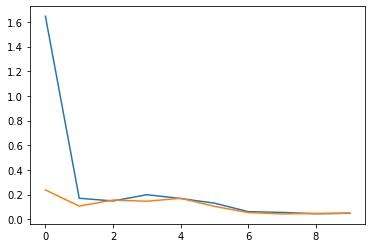

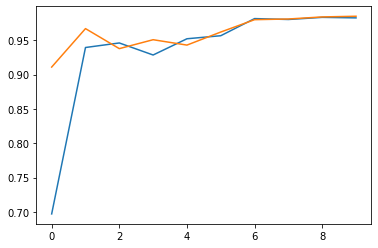

In [37]:
plt.plot(hist[0][0:10])
plt.plot(hist[2][0:10])
plt.show()

plt.plot(hist[1][0:10])
plt.plot(hist[3][0:10])
plt.show()


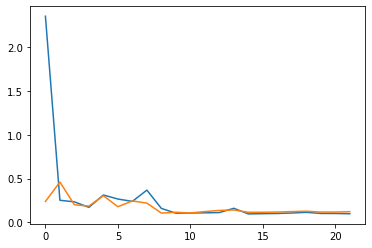

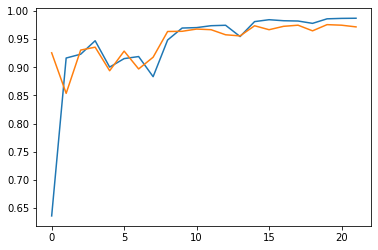

In [72]:
plt.plot(hist[0][0:])
plt.plot(hist[2][0:])
plt.show()

plt.plot(hist[1][0:])
plt.plot(hist[3][0:])
plt.show()


In [0]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TEST), val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=117, shuffle=False, num_workers=8)

In [16]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 117
    Root location: fruits_vegetables/TEST
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [86]:
model.eval()

test_predictions = []
test_img_paths = []

running_loss = 0.
running_acc = 0.

for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        preds_class = preds.argmax(dim=1)
        running_acc += (preds_class == labels.data).float().sum().cpu()


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


In [87]:
running_acc / 117, 117 - running_acc

(tensor(0.8376), tensor(19.))

In [0]:
running_acc / 117, 117 - running_acc

(tensor(0.7863), tensor(25.))

In [0]:
(117-9)/117

0.9230769230769231

In [0]:
for img inputs
        show_input(inputs)


In [0]:
model.